# TP 14: Predicting dynamics with Neural-ODE

**The goal of this pratical is use machine learning models to predict the
evolution of dynamical systems driven by physical laws, *e.g.* ordinary
Differential Equations (ODE).**

Let us considers a physcial system in Newtonian mechanichs composed of a
**damped pendulum**, with length $l$ and mass $m$, and $\theta$ being the
angle with respect to the vertical direction:

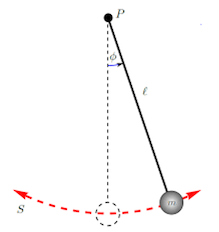

**Let us denote $\dot{\theta_t}:=\frac{d\theta}{dt}$ and
$\ddot{\theta}_t:=\frac{d^2\theta}{dt^2}$ as the first and second temporal
derivatives of $\theta$.** The dynamics of the pendulum is driven bt the
following ODE on $\theta$:


\begin{equation}
    \ddot{\theta_t} + \omega_0^2~ sin\left(\theta_t\right) + \alpha \dot{\theta}_t = 0
\end{equation}

where $\omega_0 = \sqrt{\frac{g}{l}}$ ($g$ is the gravitational constant), and
$\alpha = \frac{k}{ml^2}$ is the friction coefficient.

In the general case, the ODE in (1) does not have a closed-form
solution. Let us denote as $\mathbf{Y}_t=(\theta_t, \dot{\theta}_t)$ the 2d
state vector of the pendulum.



**<u>Question 1:</u> show that
 $\dot{\mathbf{Y}_t}=f\left({\mathbf{X}_t}\right)$, *i.e* that the evolution
 of $\mathbf{Y}$ follows a first-order ODE. Give the expression of f.**

**<u> Answer 1: </u>**

By simply differentiating at t, we get:
\begin{equation}
    \dot{\mathbf{Y}} = \Big( \begin{array}{c} \dot{\theta}\\ -{\omega}_0^2 \sin(\theta_t) - \alpha \dot{\theta}(t) \end{array} \Big)
\end{equation}


From a given initial condition $\mathbf{Y}_0=(\theta_0, \dot{\theta}_0)$, we
can estimate the state vector $\mathbf{Y}_t$ at any time $t$:

\begin{equation} \mathbf{Y}_t = \mathbf{Y}_0 + \int_0^t \dot{\mathbf{Y}_t} ~dt
= \mathbf{Y}_0 + \int_0^t f\left(\mathbf{Y}_t\right) dt
\end{equation}

where $f\left( \mathbf{Y}_t \right)$ only depends on the current state
$\mathbf{Y}_t$ at time $t$. The integral in Eq (\ref{eq2}) can be approximated
with numerical schemes. The Euler method is simplest one (see figure below):
starting from $\mathbf{Y}_0$, we have $\mathbf{Y}_{t+1} = \mathbf{Y}_{t} +
f\left(\mathbf{Y}_t\right)$ $\forall t>1$. The has been extensive studies for
developing improved numerical solvers in the last centuries, e.g. different
orders of Runge-Kutta solvers.

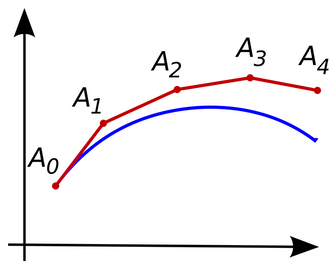


## Part I. Generating damped pendulum simulations
First, lets do some import

In [13]:
!pip install torchdiffeq

In [14]:
import math, shelve
import os

from collections import OrderedDict

import torch
import numpy as np
from scipy.integrate import solve_ivp

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim

from torchdiffeq import odeint_adjoint, odeint

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Running on device: {}".format(device))

Running on device: cuda:0


### I.a) DampledPendulum

**We will write a DampledPendulum Dataset, which simulates different pendulum trajectories from differents initial conditions. Fill the code in the code in the following DampledPendulum class. We use the following setting:** $\omega_0^2= \frac{\Pi}{6}$, $\alpha= 0.2$, time hoziron : 10, with $dt=0.5$

You have to fill the `__init__`, `__len__` and  `__getitem__` functions. For `__getitem__`, the goal is to simulate a given trajectory from an initial condition:
- The function `_get_initial_condition` is provided
- To perform the simulation in `__getitem__`, you need to:
    - Call the `_get_initial_condition`
    - Call the solver: we will use the solve_ivp method from from `scipy.integrate`, using the 'DOP853' method (Explicit Runge-Kutta method of order 8).
- Since the simulation is computationally demanding, it can be a good idea to store the states in the class

In [15]:
class DampledPendulum(Dataset):
    def __init__(self, num_seq, time_horizon, dt):#, params=None, group='train'):

        super().__init__()

        # À compléter...
        # assert False, 'Code non implémenté'
        self.omega0_square= (2 * np.pi / 6) ** 2
        self.alpha = 0.2
        self.len = num_seq
        self.time_horizon = time_horizon
        self.dt = dt
        self.data = [None] * num_seq

    def _get_initial_condition(self):
        """Returns the vector of initial conditions"""
        y0 = np.random.randn(2) * 2.0 - 1
        r = np.random.rand() + 1.3
        y0 = y0 / np.sqrt((y0 ** 2).sum()) * r

        return y0

    def _get_state_derivative(self, t, x):  # coords = [q,p]
        q, p = np.split(x, 2)
        dqdt = p
        dpdt = -self.omega0_square * np.sin(q) - self.alpha * p
        return np.concatenate([dqdt, dpdt], axis=-1)


    def __getitem__(self, index: int):
        t_eval = torch.arange(0, self.time_horizon, self.dt)

        if self.data[index] is None:
            y0 = self._get_initial_condition()
            # À compléter...
            # assert False, 'Code non implémenté'
            states = solve_ivp(
                self._get_state_derivative,
                (0, self.time_horizon),
                y0,
                method='DOP853',
                t_eval=t_eval,
                rtol=1e-10,
            ).y
            self.data[index] = torch.tensor(states).float()
        else:
            states = self.data[index]

        return {'states': states, 't': t_eval.float()}


    def __len__(self):
        # À compléter... #
        # assert False, 'Code non implémenté'
        return self.len


### I.b) Train/test data generation
**We can now define train and test dataloader** (use 25 train/test sequences with a batch size of 25).
**Plot the resulting trajectories ($\theta$ and optionally $\dot{\theta}$).**

In [16]:
#path = "./exp2/pendulum/pendulum"

num_seq = 25
time_horizon = 20
dt = 0.5
dataset_train = DampledPendulum(num_seq,time_horizon,dt)
dataset_test  = DampledPendulum(num_seq,time_horizon,dt)


batch_size = 25
dataloader_train_params = {
        'dataset'    : dataset_train,
        'batch_size' : batch_size,
        'num_workers': 0,
        'pin_memory' : True,
        'drop_last'  : False,
        'shuffle'    : True,
}

dataloader_test_params = {
    'dataset'    : dataset_test,
    'batch_size' : batch_size,
    'num_workers': 0,
    'pin_memory' : True,
    'drop_last'  : False,
    'shuffle'    : False,
}

train_loader = DataLoader(**dataloader_train_params)
test_loader = DataLoader(**dataloader_test_params)

In [17]:
# Show one item of the dataset

dataset_train[0]

{'states': array([[ 1.7749145 ,  1.4884456 ,  0.97337536,  0.30075718, -0.38049663,
         -0.90487096, -1.17980116, -1.18997441, -0.95940856, -0.54190369,
         -0.03459801,  0.43304184,  0.7503199 ,  0.86317707,  0.77003333,
          0.50762718,  0.14692885, -0.21635841, -0.49076289, -0.61897256,
         -0.58646427, -0.41554537, -0.15816467,  0.11464587,  0.33246574,
          0.44642859,  0.43924487,  0.32412002,  0.1388087 , -0.06404159,
         -0.23131567, -0.32425835, -0.32704055, -0.24756046, -0.11318231,
          0.03716078,  0.16373772,  0.23672586,  0.24294077,  0.18718832],
        [-0.32616937, -0.81348529, -1.2247351 , -1.41367438, -1.25231772,
         -0.81464459, -0.28162974,  0.23267807,  0.67238858,  0.96503176,
          1.01894371,  0.8132827 ,  0.43820162,  0.01327689, -0.37357697,
         -0.65218022, -0.75762438, -0.66389009, -0.41440423, -0.09387623,
          0.21626224,  0.44979083,  0.55533865,  0.51166305,  0.34300828,
          0.10715397, -0.13

<Figure size 2000x1000 with 0 Axes>

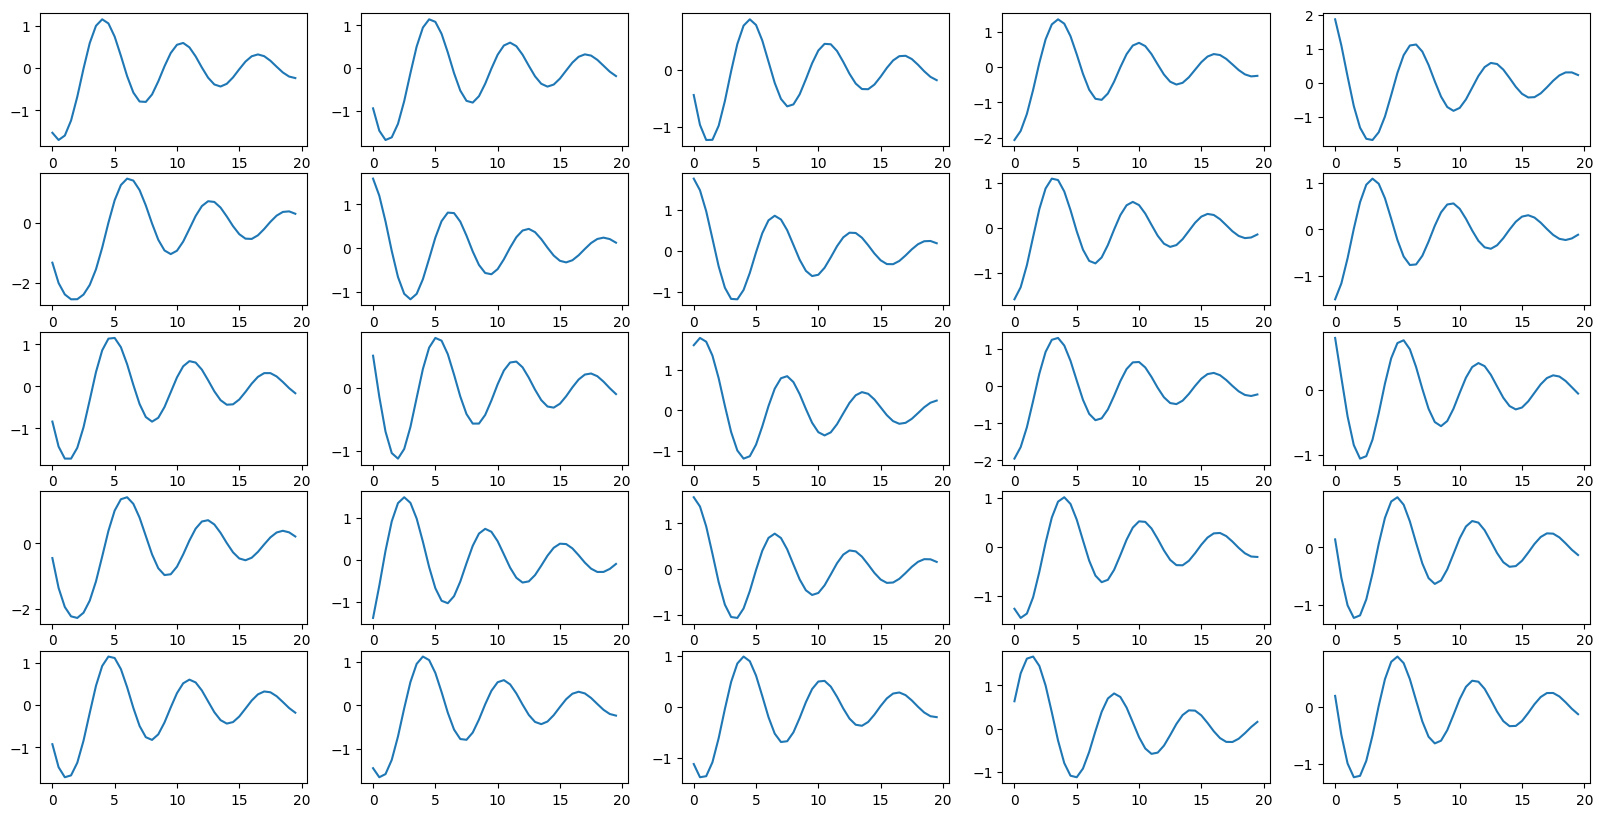

In [18]:
data = next(iter(train_loader))
draw_dottheta=False

plt.figure()
plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(5, 5)

for i in range(5):
    for j in range(5):
        #fig, (ax1, ax2) = plt.subplots(i+1, j+1)
        #plt.plot(data['t'][i*5+j],data['states'][i*5+j,0,:])
        axs[i, j].plot(data['t'][i*5+j],data['states'][i*5+j,0,:])


if(draw_dottheta==True):
    fig, axs = plt.subplots(5, 5)
    for i in range(5):
        for j in range(5):
            axs[i, j].plot(data['t'][i*5+j],data['states'][i*5+j,1,:])

<Figure size 2000x1000 with 0 Axes>

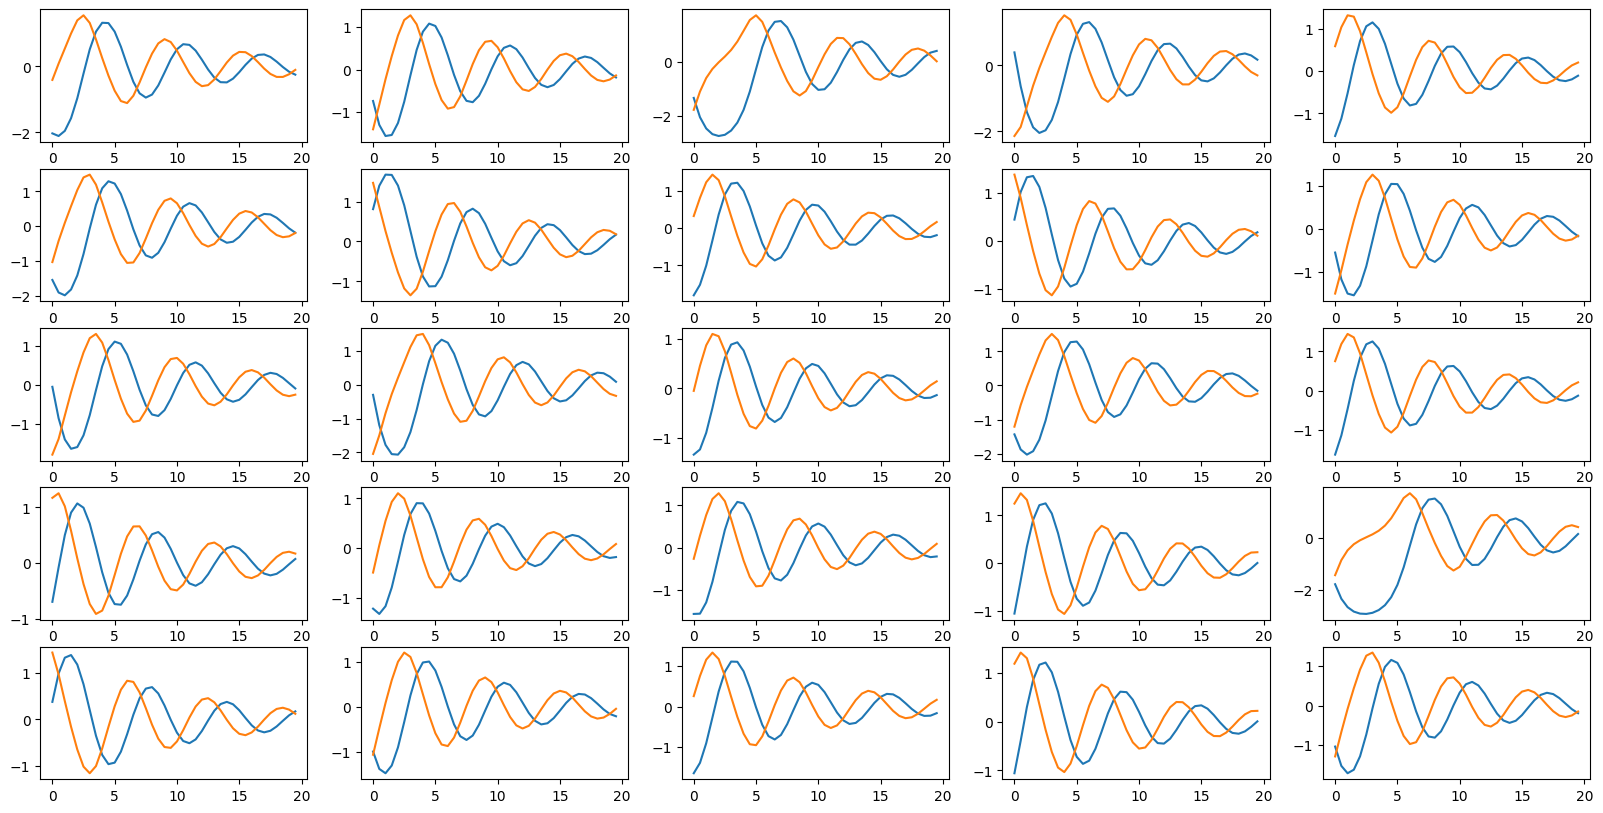

In [19]:
data_test = next(iter(test_loader))

plt.figure()
plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(5, 5)
draw_dottheta = True

for i in range(5):
    for j in range(5):
        #fig, (ax1, ax2) = plt.subplots(i+1, j+1)
        #plt.plot(data['t'][i*5+j],data['states'][i*5+j,0,:])
        axs[i, j].plot(data_test['t'][i*5+j],data_test['states'][i*5+j,0,:])

if draw_dottheta:
    for i in range(5):
        for j in range(5):
            #fig, (ax1, ax2) = plt.subplots(i+1, j+1)
            #plt.plot(data['t'][i*5+j],data['states'][i*5+j,0,:])
            axs[i, j].plot(data_test['t'][i*5+j],data_test['states'][i*5+j,1,:])

### Plot initial condition distribution

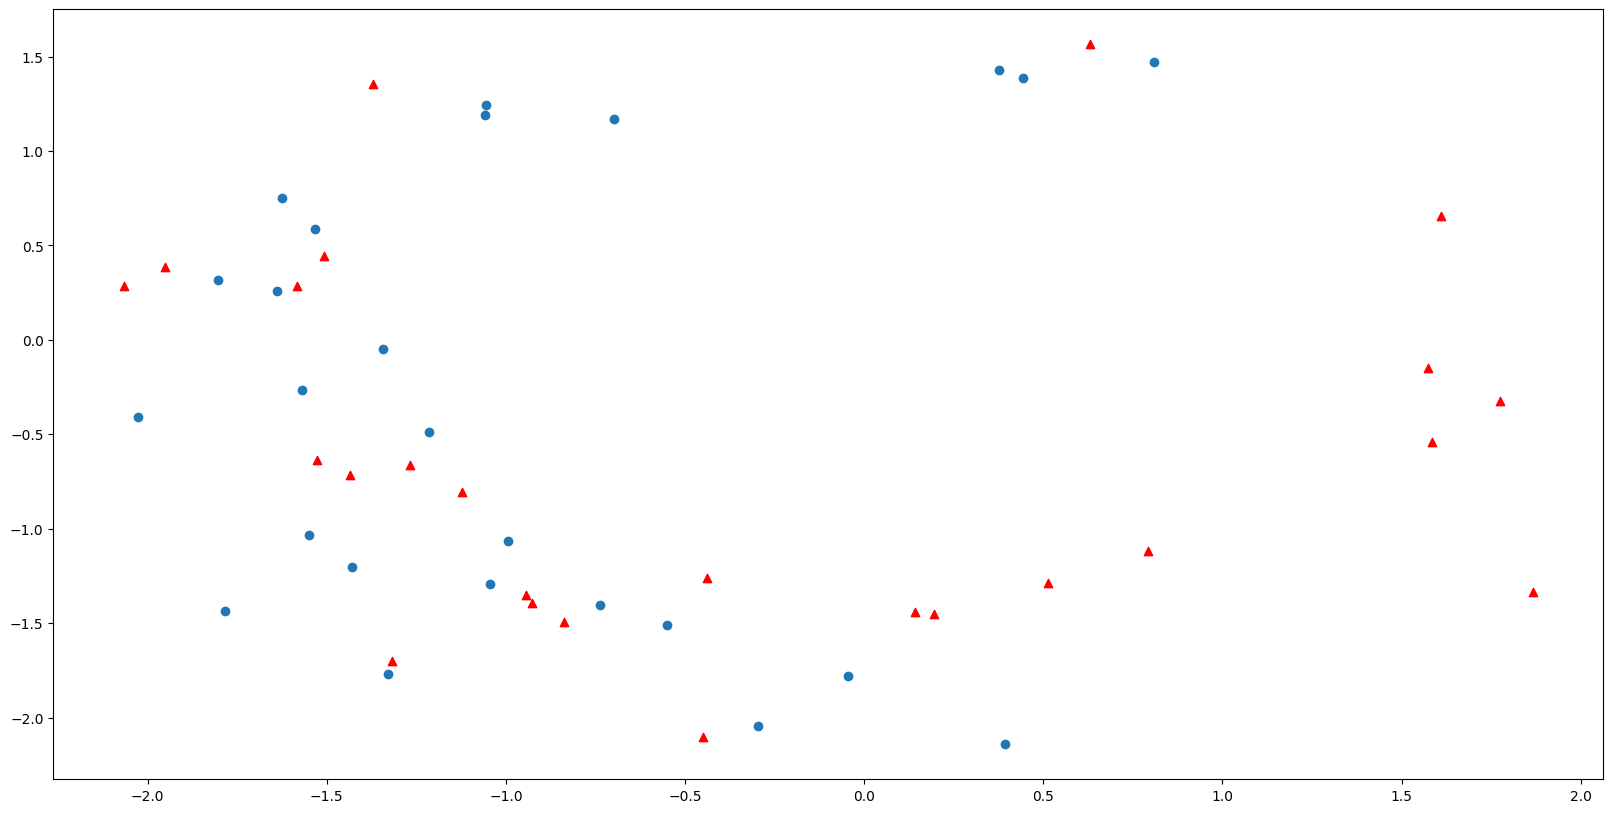

In [20]:
# data = data_test
theta0_train = data['states'][:,0,0]
dtheta0_train = data['states'][:,1,0]

theta0_test = data_test['states'][:,0,0]
dtheta0_test = data_test['states'][:,1,0]

plt.figure()
plt.scatter(theta0_train,dtheta0_train, marker='^', c='r')
plt.scatter(theta0_test, dtheta0_test)


## 2) Predicting trajectories with Neural-ODE

The goal is to use the Neural-ODE method [1] to predict the future trajectory from an initial condition. **More precisely, the idea is to define a parametric model, *e.g.* an neural network, to predict the state's derivative from the current state value: $\dot{\mathbf{Y}_t}=f_{\theta}\left({\mathbf{Y}_t}\right)$, with $\theta$ being the neural net parameters. From an initial condition $\mathbf{Y}_0$ and $f_{\theta}\left({\mathbf{Y}_t}\right)$, we can then use Eq (2) to predict the full predicted trajectory $\hat{\mathbf{Y}}$. The goal is to optimize $\theta$ parameters such that predicted trajectories are close to the GT trajectories in the training set.**

\begin{equation}
\hat{\mathbf{Y}_t}  = \mathbf{Y}_0 + \int_0^t f_{\theta}\left(\mathbf{Y}_t\right) dt \tag{2},
\end{equation}


**Let's fill the DerivativeEstimator class to predict the the state's derivative.** We will use a simple MLP (2 hiddenn layers + ReLU) for prediction since the state is a 2D vector.


In [21]:
class DerivativeEstimator(nn.Module):
    def __init__(self, n_state, n_hidden):
        super().__init__()
        # À compléter...
        # assert False, 'Code non implémenté'
        self.n_state = n_state
        self.n_hidden = n_hidden
        self._estimator = nn.Sequential(
            nn.Linear(n_state, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_state),
        )

    def forward(self, t, state):
        # À compléter...
        #res = self._estimator(torch.cat((state.unsqueeze(1), torch.full_like(state, t.item()).unsqueeze(1)), dim=1))[:,0]
        return self._estimator(state)

**The forecasterwill perform the prediction from a initial state $y_0$**. To perform the numerical integration, we use the [`odeint` method from torchdiffeq](https://github.com/rtqichen/torchdiffeq). We will use the generic 'rk4' solver to perform numerical integration. **Fill the following  Forecaster class with:**
- A constructor creating a reference to an DerivativeEstimator instance
- the forward method calls the `odeint` method to perform integration from an initial $y_0$ state. **N.B.**: the output dimensions after calling `odeint` will be `T x batch_size x n_c`, swap them to fit the requested Pytorch standard (`batch_size x n_c X T`)

In [22]:
class Forecaster(nn.Module):
    def __init__(self, n_state, n_hidden, method='rk4'):
        super().__init__()

        # À compléter...
        # assert False, 'Code non implémenté'
        self._get_derivative = DerivativeEstimator(n_state, n_hidden)
        self.method = method
        #self._forecast = lambda y,t: odeint(self._get_derivative, y, t, method = method)

    def forward(self, y0: torch.Tensor, t: torch.Tensor):
        """Computes the $y_t$ prediction at time $t$
        given the initial state of size (B x N_c x T)
        """
        forecast = odeint(self._get_derivative, y0, t, method = self.method)
        return forecast.permute(1, 2, 0)

### Write the training loop!
For each batch:
- Get the first state of each training trajectory
- Perform prediction of the forecaster for each time step of the horizon
- We will use a simple MSE loss between the ground truth and predicted trajectories.
- Use an Adam optimizer (default paramters)
- Plot the train / test trajectories

In [23]:
n_state = 2
n_hidden = 200
n_epochs = 1001
tau_1 = 5e-4

forecaster_net = Forecaster(n_state,n_hidden)
optimizer = optim.Adam(forecaster_net.parameters(), lr=tau_1, betas=(0.9, 0.999))
traj_loss = nn.MSELoss()

pbar = tqdm(range(n_epochs))
for e in pbar:
    for sample in train_loader:
      states = sample['states']
      y0, t = states[:, :, 0], sample['t'][0]
      y_pred = forecaster_net(y0, t)

      loss = traj_loss(y_pred, states)
      pbar.set_description(f"Loss : {loss.item():.4f}")

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

Loss : 0.0003: 100%|██████████| 1001/1001 [01:55<00:00,  8.68it/s]


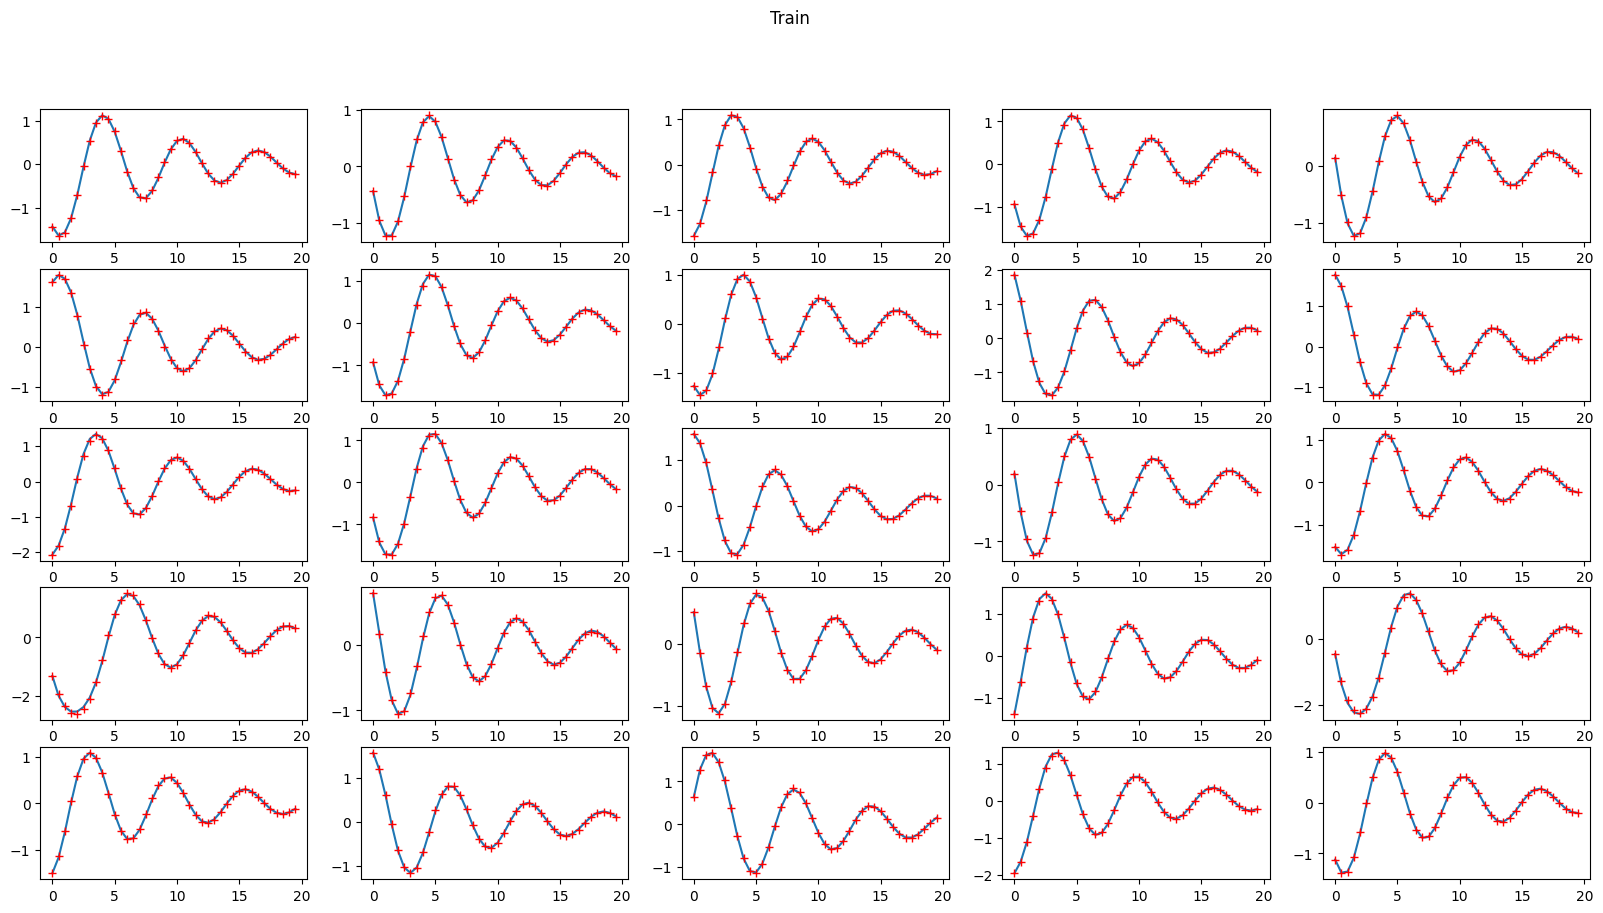

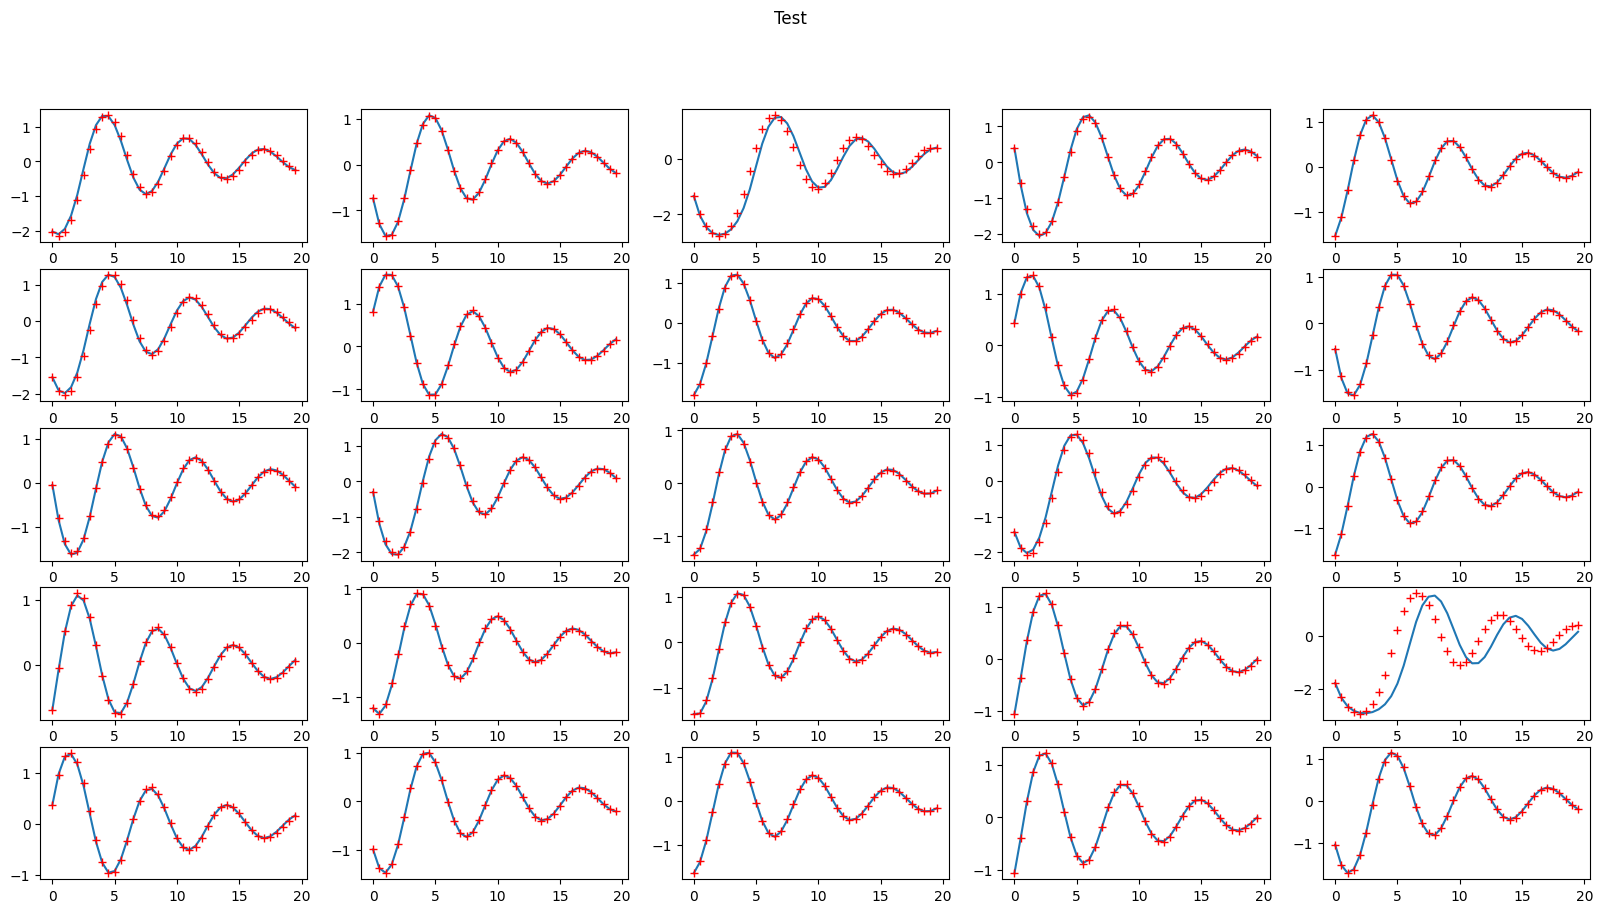

In [24]:
# The code below plots the predicted values

# batch contains one batch of samples
batch = next(iter(train_loader))
batch_test = next(iter(test_loader))
# pred contains the prediction
pred = forecaster_net(batch['states'][:, :, 0], batch['t'][0])
pred_test = forecaster_net(batch_test['states'][:, :, 0], batch['t'][0])

#plt.figure()
#plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(5, 5)
p = (pred.detach()).numpy()
ptest = pred_test.detach().numpy()

for i in range(5):
    for j in range(5):
        axs[i, j].plot(batch['t'][i*5+j],batch['states'][i*5+j,0,:], batch['t'][i*5+j],p[i*5+j,0,:], 'r+')
fig.suptitle("Train")
plt.show()

fig, axs = plt.subplots(5, 5)
for i in range(5):
    for j in range(5):
        axs[i, j].plot(batch_test['t'][i*5+j],batch_test['states'][i*5+j,0,:], batch_test['t'][i*5+j],ptest[i*5+j,0,:], 'r+')
fig.suptitle("Test")
plt.show()

# Bonus
Experiment Neural ODE for **replacing residual networks with ODEs for supervised learning**: see section 3 in [this paper](https://proceedings.neurips.cc/paper/2018/file/69386f6bb1dfed68692a24c8686939b9-Paper.pdf).


[1] **Neural Ordinary Differential Equations.**
Ricky T. Q. Chen, Yulia Rubanova, Jesse Bettencourt, David K. Duvenaud.
NeurIPS 2018.

<!--bibtex

@inproceedings{nODE-NEURIPS2018,
 author = {Chen, Ricky T. Q. and Rubanova, Yulia and Bettencourt, Jesse and Duvenaud, David K},
 booktitle = {Advances in Neural Information Processing Systems},
 editor = {S. Bengio and H. Wallach and H. Larochelle and K. Grauman and N. Cesa-Bianchi and R. Garnett},
 pages = {},
 publisher = {Curran Associates, Inc.},
 title = {Neural Ordinary Differential Equations},
 url = {https://proceedings.neurips.cc/paper/2018/file/69386f6bb1dfed68692a24c8686939b9-Paper.pdf},
 volume = {31},
 year = {2018}
}

... Other Bibtex entries go here.

-->

<!--bibtex

@inproceedings{nODE-NEURIPS2018,
 author = {Chen, Ricky T. Q. and Rubanova, Yulia and Bettencourt, Jesse and Duvenaud, David K},
 booktitle = {Advances in Neural Information Processing Systems},
 editor = {S. Bengio and H. Wallach and H. Larochelle and K. Grauman and N. Cesa-Bianchi and R. Garnett},
 pages = {},
 publisher = {Curran Associates, Inc.},
 title = {Neural Ordinary Differential Equations},
 url = {https://proceedings.neurips.cc/paper/2018/file/69386f6bb1dfed68692a24c8686939b9-Paper.pdf},
 volume = {31},
 year = {2018}
}

... Other Bibtex entries go here.

-->